# Circles (tensorflow)

In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dOD.tf_model.model import UNet
from dOD.tf_model.datasets import circles
from dOD.tf_model.trainer import Trainer
from dOD.tf_model.layers import crop_image_labels_to_shape

In [2]:
circle_model = UNet(input_shape=(200, 200, 1), kernel_shape=(3, 3),
                    root_feature=16, depth=3, drop_rate=0.2, num_classes=circles.CLASSES)
circle_model.build_net()
circle_model.compile(optimizer='rmsprop')
circle_model.describle()

-------- input shape: (None, 200, 200, 1)
    > layer 0 shape: (None, 200, 200, 16)
    > layer 1 shape: (None, 200, 200, 16)
    downstream layer 1 shape: (None, 200, 200, 16)
        > layer 0 shape: (None, 100, 100, 32)
        > layer 1 shape: (None, 100, 100, 32)
        downstream layer 2 shape: (None, 100, 100, 32)
            > layer 0 shape: (None, 50, 50, 64)
            > layer 1 shape: (None, 50, 50, 64)
            bottom layer 3 shape: (None, 50, 50, 64)
        > layer 0 shape: (None, 100, 100, 32)
        > layer 1 shape: (None, 100, 100, 32)
        upstream layer 2 shape: (None, 100, 100, 32)
    > layer 0 shape: (None, 200, 200, 16)
    > layer 1 shape: (None, 200, 200, 16)
    upstream layer 1 shape: (None, 200, 200, 16)
-------- output shape: (None, 200, 200, 2)


In [3]:
train_ds, validation_ds, test_ds = circles.load_data(1000, nx=200, ny=200, splits=(0.7, 0.2, 0.1))

In [4]:
trainer = Trainer(save_ckpt=False)

In [5]:
history = trainer.fit(circle_model.net, train_ds,
                      validation_dataset=validation_ds, epochs=25, batch_size=32)

Epoch 1/25
22/22 [==============================] - 8s 355ms/step - loss: 0.2814 - binary_crossentropy: 0.2814 - binary_accuracy: 0.9609 - val_loss: 0.2200 - val_binary_crossentropy: 0.2200 - val_binary_accuracy: 0.9701
Epoch 2/25
22/22 [==============================] - 7s 307ms/step - loss: 0.1678 - binary_crossentropy: 0.1678 - binary_accuracy: 0.9699 - val_loss: 0.1379 - val_binary_crossentropy: 0.1379 - val_binary_accuracy: 0.9702
Epoch 3/25
22/22 [==============================] - 7s 310ms/step - loss: 0.0992 - binary_crossentropy: 0.0992 - binary_accuracy: 0.9787 - val_loss: 0.0521 - val_binary_crossentropy: 0.0521 - val_binary_accuracy: 0.9863
Epoch 4/25
22/22 [==============================] - 7s 307ms/step - loss: 0.0552 - binary_crossentropy: 0.0552 - binary_accuracy: 0.9877 - val_loss: 0.0409 - val_binary_crossentropy: 0.0409 - val_binary_accuracy: 0.9887
Epoch 5/25
22/22 [==============================] - 7s 310ms/step - loss: 0.0453 - binary_crossentropy: 0.0453 - binary_

In [6]:
prediction = circle_model.net.predict(test_ds.batch(batch_size=5))

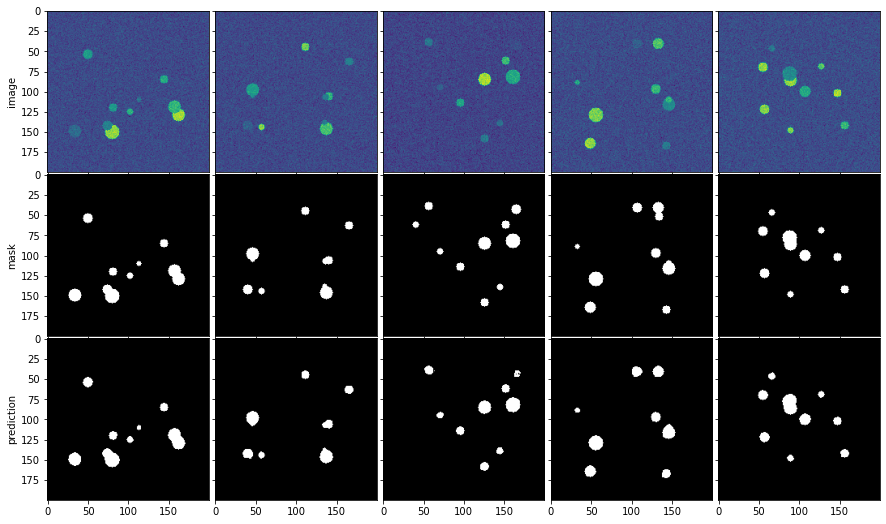

In [7]:
N = 5
fig, ax = plt.subplots(3, N, sharex=True, sharey=True,
                       figsize=(N * 3, 9), gridspec_kw={'wspace': 0.01, 'hspace': 0.015})
dataset = test_ds.map(crop_image_labels_to_shape(prediction.shape[1:]) )

for i, (img, label) in enumerate(dataset.take(N)):
    ax[0][i].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax[1][i].imshow(np.argmax(label, axis=-1), cmap=plt.cm.gray)
    ax[2][i].imshow(np.argmax(prediction[i, ...], axis=-1), cmap=plt.cm.gray)
for i, x in enumerate(['image', 'mask', 'prediction']):
    ax[i][0].set_ylabel(x);

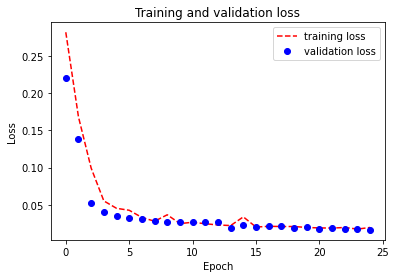

In [8]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(25), train_loss, 'r--', label='training loss')
plt.plot(range(25), val_loss, 'bo', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()